In [1]:
import numpy as np
import tifffile as tif
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage.morphology import white_tophat, disk, ball


Change file paths here 

In [2]:
img = tif.imread(
    "/Volumes/nedividata/Amy/files_for_amy_fromJoe/SOM023Files_afterNewUnmixingAndScoring/NewUnmixing_concatenatedimages_blinded/SOM023_Image0.tif"
)

# pick channel explicitly (adjust if needed)
other_channel = img[:, 0, :, :]   # (Z,Y,X)
print(other_channel.shape)

# df = pd.read_csv(
#     "/Volumes/nedividata/Amy/files_for_amy_fromJoe/SOM023Files_afterNewUnmixingAndScoring/PunctaScoring/branch2/Image0_branch2.csv"
# )
# pts = df[["axis-0", "axis-1", "axis-2"]].to_numpy()


(189, 800, 800)


In [3]:
boutons =  img[:, 2, :, :]

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "/Volumes/nedividata/Amy/files_for_amy_fromJoe/SOM023Files_afterNewUnmixingAndScoring/PunctaScoring/branch2/Image0_branch2.csv"
)


label_col_candidates = ["label"]
label_col = next((c for c in label_col_candidates if c in df.columns), None)

# coords
coord_cols = ["axis-0", "axis-1", "axis-2"]  
pts = df[coord_cols].to_numpy(np.float32)

# keep label ids (optional, but handy)
if label_col is not None:
    labels = df[label_col].to_numpy()
else:
    labels = None  


In [5]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

Z, H, W = other_channel.shape
Z_SCALE = 4  # <-- critical: image z -> point z

# 1) assign each point to the nearest image slice
# pts[:,0] is in scaled z units
z_img_idx = np.clip(
    np.rint(pts[:, 0] / Z_SCALE).astype(int),
    0, Z - 1
)

# image planes that actually contain points
z_planes = np.unique(z_img_idx)

if len(z_planes) == 0:
    raise ValueError("No points map to valid image z planes.")

# OPTIONAL: expand by padding in image-slice units
z_pad = 1
if z_pad > 0:
    z_planes = np.unique(
        np.clip(
            np.concatenate([z_planes + dz for dz in range(-z_pad, z_pad + 1)]),
            0, Z - 1
        )
    )

# 2) restricted volume from those planes
vol = other_channel[z_planes].astype(np.float32)

# 3) smooth (do NOT over-smooth in z for sparse planes)
vol_s = gaussian_filter(vol, sigma=(0.0, 1.0, 1.0))

# 4) find peaks in restricted volume
coords3d = peak_local_max(
    vol_s,
    min_distance=1,
    threshold_abs=0,
    exclude_border=False
)

print("3D peaks (restricted planes):", len(coords3d))
if len(coords3d) == 0:
    raise ValueError("No 3D peaks found.")

# 5) map peak coordinates back to POINT z-units
coords3d_global = coords3d.copy()

# image slice index → scaled z
coords3d_global[:, 0] = z_planes[coords3d[:, 0]] * Z_SCALE

# coords3d_global is now (z,y,x) in SAME coordinate system as pts


3D peaks (restricted planes): 76234


In [6]:
from scipy.spatial import cKDTree
import numpy as np

Z, H, W = other_channel.shape
Z_SCALE = 4

# assign each point to nearest scaled plane (multiple of 4)
z_scaled = np.rint(pts[:,0] / Z_SCALE).astype(int) * Z_SCALE

pts_snapped_all = pts.copy()
max_snap_px = 100

z_tol_planes = 2
z_tol_scaled = z_tol_planes * Z_SCALE  # e.g. 2 * 4 = 8

for z in np.unique(z_scaled):
    idx_p = np.where(z_scaled == z)[0]

    # allow peaks on z, z±4, z±8 (i.e., within 2 image planes)
    mask_peaks = np.abs(coords3d_global[:, 0] - z) <= z_tol_scaled

    if not np.any(mask_peaks):
        print(f"z={z:4d} | peaks=0 in ±{z_tol_planes} planes | snapped 0 / {len(idx_p)} (kept original)")
        continue

    peaks = coords3d_global[mask_peaks]             # (P,3) in (z,y,x)
    peaks_xy = peaks[:, 1:3].astype(np.float32)     # (y,x) for distance
    query_xy = pts[idx_p][:, 1:3].astype(np.float32)

    #nearest by xy
    tree = cKDTree(peaks_xy)
    dist, nn = tree.query(query_xy, k=1)

    snapped_xy = peaks_xy[nn].copy()

    too_far = dist > max_snap_px
    snapped_xy[too_far] = query_xy[too_far]

    # write back XY
    pts_snapped_all[idx_p, 1:3] = snapped_xy

    # OPTIONAL: also move z to the peak's z (only if you want reassignment across planes)
    # snapped_z = peaks[nn, 0]
    # pts_snapped_all[idx_p, 0] = np.where(too_far, pts_snapped_all[idx_p, 0], snapped_z)

    print(
        f"z={z:4d} | peaks={mask_peaks.sum():4d} (±{z_tol_planes} planes) | "
        f"snapped {(~too_far).sum():4d} / {len(idx_p):4d}"
    )


z=   0 | peaks=7496 (±2 planes) | snapped    1 /    1
z= 504 | peaks=17354 (±2 planes) | snapped    1 /    1
z= 512 | peaks=22077 (±2 planes) | snapped    2 /    2
z= 520 | peaks=22398 (±2 planes) | snapped    1 /    1
z= 524 | peaks=22785 (±2 planes) | snapped    2 /    2
z= 536 | peaks=23294 (±2 planes) | snapped    2 /    2
z= 540 | peaks=23301 (±2 planes) | snapped    2 /    2
z= 544 | peaks=23380 (±2 planes) | snapped    3 /    3
z= 548 | peaks=24047 (±2 planes) | snapped    2 /    2
z= 552 | peaks=19363 (±2 planes) | snapped    1 /    1


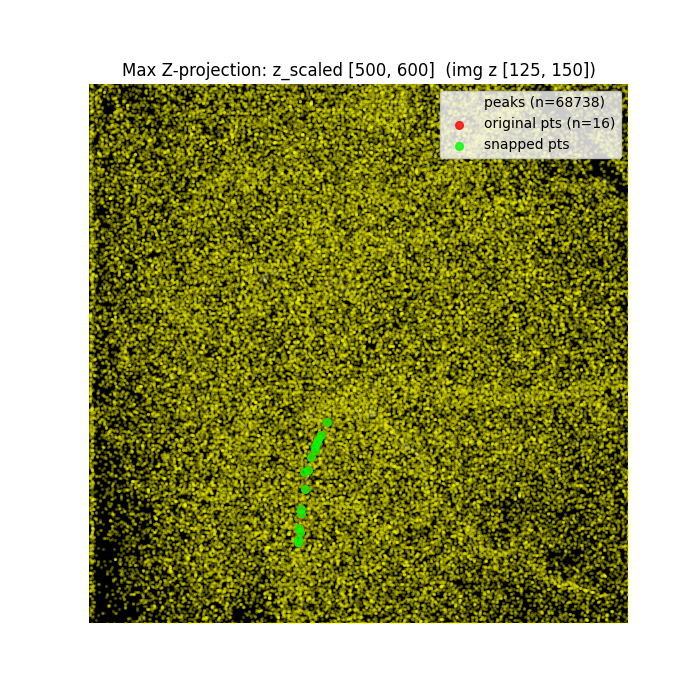

In [7]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

Z, H, W = other_channel.shape
Z_SCALE = 4

# choose a scaled-z range to project (edit these)
zmin_scaled = 500
zmax_scaled = 600

# convert to image slice indices (inclusive range)
zmin_img = int(np.floor(zmin_scaled / Z_SCALE))
zmax_img = int(np.ceil (zmax_scaled / Z_SCALE))
zmin_img = max(0, zmin_img)
zmax_img = min(Z-1, zmax_img)

# max projection
proj = other_channel[zmin_img:zmax_img+1].max(axis=0)

# filter points to that z-range (scaled)
in_range = (pts[:,0] >= zmin_scaled) & (pts[:,0] <= zmax_scaled)

# OPTIONAL: filter peaks too
peaks_in_range = (coords3d_global[:,0] >= zmin_scaled) & (coords3d_global[:,0] <= zmax_scaled)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(proj, cmap="gray")

# peaks (often dense; comment out if cluttered)
ax.scatter(coords3d_global[peaks_in_range, 2], coords3d_global[peaks_in_range, 1],
           s=2, c="yellow", alpha=0.2, label=f"peaks (n={peaks_in_range.sum()})")

# original points
ax.scatter(pts[in_range, 2], pts[in_range, 1],
           s=30, c="red", alpha=0.8, label=f"original pts (n={in_range.sum()})")

# snapped points
ax.scatter(pts_snapped_all[in_range, 2], pts_snapped_all[in_range, 1],
           s=30, c="lime", alpha=0.8, label="snapped pts")
idx = np.where(in_range)[0]
for i in idx:
    x0, y0 = pts[i,2], pts[i,1]
    x1, y1 = pts_snapped_all[i,2], pts_snapped_all[i,1]
    if (x0 != x1) or (y0 != y1):
        ax.plot([x0, x1], [y0, y1], linewidth=0.8, alpha=0.6)

ax.set_title(f"Max Z-projection: z_scaled [{zmin_scaled}, {zmax_scaled}]  (img z [{zmin_img}, {zmax_img}])")
ax.axis("off")
ax.legend(loc="upper right")
plt.show()


In [14]:
import numpy as np
import pandas as pd
import napari
from skimage.draw import disk
from skimage.filters import threshold_otsu


Z_SCALE = 4               
DISK_R = 2         
OTSU_OFFSET = 30     
OUT_CSV = "/Users/amyzheng/Desktop/out/done34.csv"

LABEL_COL_CANDIDATES = [ "label"]

Z, H, W = other_channel.shape

boutons = img[:, 2, :, :].astype(np.float32)    

sn = pts_snapped_all.astype(np.float32)         

z_idx = np.clip(np.rint(sn[:, 0] / Z_SCALE).astype(int), 0, Z - 1)
yy    = np.clip(np.rint(sn[:, 1]).astype(int), 0, H - 1)
xx    = np.clip(np.rint(sn[:, 2]).astype(int), 0, W - 1)


disk_mask = np.zeros((Z, H, W), dtype=np.uint8)
for zi, y, x in zip(z_idx, yy, xx):
    rr, cc = disk((y, x), DISK_R, shape=(H, W))
    disk_mask[zi, rr, cc] = 1

#threshold is here 
t = threshold_otsu(boutons) + OTSU_OFFSET
boutons_mask = boutons > t                      
coloc_mask = boutons_mask & (disk_mask.astype(bool))

print(f"boutons threshold = {t:.2f} | boutons_mask fraction = {boutons_mask.mean():.6f}")


overlap_counts = np.zeros(len(df), dtype=np.int32)
disk_areas     = np.zeros(len(df), dtype=np.int32)

for i, (zi, y, x) in enumerate(zip(z_idx, yy, xx)):
    rr, cc = disk((y, x), DISK_R, shape=(H, W))
    disk_areas[i] = len(rr)
    overlap_counts[i] = int(boutons_mask[zi, rr, cc].sum())

df[f"disk_area_px_r{DISK_R}"] = disk_areas
df[f"bouton_overlap_px_r{DISK_R}"] = overlap_counts
df[f"bouton_overlap_frac_r{DISK_R}"] = overlap_counts / np.clip(disk_areas, 1, None)

df.to_csv(OUT_CSV, index=False)
print("wrote:", OUT_CSV)

# --------------------
# 4) NAPARI VISUALIZATION (same viewer)
# --------------------
def to_image_zyx(points_zyx_scaled):
    """(z_scaled,y,x) -> (z_img,y,x) for viewing on (Z,Y,X) stacks."""
    p = points_zyx_scaled.astype(np.float32, copy=True)
    p[:, 0] /= Z_SCALE
    return p

pts_img = to_image_zyx(pts)
pts_snapped_img = to_image_zyx(pts_snapped_all)

peaks_img = None
if "coords3d_global" in globals() and coords3d_global is not None:
    peaks_img = to_image_zyx(coords3d_global)

viewer = napari.Viewer(ndisplay=3)

viewer.add_image(other_channel, name="other_channel", colormap="gray")
viewer.add_image(img[:, 1, :, :], name="other_channel_ch1", colormap="gray")

viewer.add_image(boutons, name="boutons (ch2)", colormap="magenta", opacity=0.6)
viewer.add_labels(boutons_mask.astype(np.uint8), name=f"boutons_mask (otsu+{OTSU_OFFSET}={t:.2f})")

viewer.add_labels(disk_mask.astype(np.uint8), name=f"snapped disks (r={DISK_R})")
viewer.add_labels(coloc_mask.astype(np.uint8), name="colocalization (disk ∩ bouton)")

viewer.add_points(
    pts_img, name=f"pts original (n={len(pts_img)})",
    size=2, face_color="red", opacity=0.8
)
viewer.add_points(
    pts_snapped_img, name="pts snapped",
    size=2, face_color="lime", opacity=0.8
)

if peaks_img is not None and len(peaks_img) > 0:
    viewer.add_points(
        peaks_img, name=f"peaks (n={len(peaks_img)})",
        size=1.5, face_color="yellow", opacity=0.2
    )

# snap lines
starts = pts_img.astype(np.float32)
ends   = pts_snapped_img.astype(np.float32)
move = np.linalg.norm(ends - starts, axis=1) > 1e-6
lines = np.stack([starts[move], ends[move]], axis=1)

viewer.add_shapes(
    lines, shape_type="line", name="snap lines",
    edge_color="cyan", edge_width=1, opacity=0.8
)

napari.run()


boutons threshold = 65.42 | boutons_mask fraction = 0.041657
wrote: /Users/amyzheng/Desktop/out/done34.csv


In [9]:
# import numpy as np
# from skimage.draw import disk

# Z, H, W = other_channel.shape
# Z_SCALE = 4
# R = 2  # disk radius in pixels

# # snapped coords in same coord system as pts (z,y,x)
# sn = pts_snapped_all.astype(np.float32)

# # map snapped z to image slice index
# z_idx = np.clip(np.rint(sn[:, 0] / Z_SCALE).astype(int), 0, Z - 1)

# # round xy to pixel indices
# yy = np.clip(np.rint(sn[:, 1]).astype(int), 0, H - 1)
# xx = np.clip(np.rint(sn[:, 2]).astype(int), 0, W - 1)

# disk_mask = np.zeros((Z, H, W), dtype=np.uint8)

# # draw disks only in their z plane
# for zi, y, x in zip(z_idx, yy, xx):
#     rr, cc = disk((y, x), R, shape=(H, W))
#     disk_mask[zi, rr, cc] = 1

# print("disk_mask dtype/shape:", disk_mask.dtype, disk_mask.shape)


In [10]:
# import numpy as np
# import pandas as pd
# from skimage.draw import disk
# from skimage.filters import threshold_otsu

# boutons = img[:, 2, :, :]          # (Z,H,W) in IMAGE z indexing
# Z, H, W = boutons.shape

# Z_SCALE = 4
# R = 4  # disk radius in pixels


# t = threshold_otsu(boutons.astype(np.float32)) + 30
# boutons_mask = boutons > t

# print("boutons threshold:", t, "boutons_mask fraction:", boutons_mask.mean())

# sn = pts_snapped_all.astype(np.float32)

# z_idx = np.clip(np.rint(sn[:, 0] / Z_SCALE).astype(int), 0, Z - 1)
# yy = np.clip(np.rint(sn[:, 1]).astype(int), 0, H - 1)
# xx = np.clip(np.rint(sn[:, 2]).astype(int), 0, W - 1)

# overlap_counts = np.zeros(len(df), dtype=np.int32)
# disk_areas = np.zeros(len(df), dtype=np.int32)  # optional: disk pixel count (near edges smaller)

# for i, (zi, y, x) in enumerate(zip(z_idx, yy, xx)):
#     rr, cc = disk((y, x), R, shape=(H, W))
#     disk_areas[i] = len(rr)
#     overlap_counts[i] = int(boutons_mask[zi, rr, cc].sum())

# # --- 4) write back into df ---
# df["bouton_overlap_px_r4"] = overlap_counts
# df["disk_area_px_r4"] = disk_areas
# df["bouton_overlap_frac_r4"] = df["bouton_overlap_px_r4"] / df["disk_area_px_r4"].clip(lower=1)

# # save
# out_csv = '/Users/amyzheng/Desktop/out/done2.csv'
# df.to_csv(out_csv, index=False)
# print("wrote:", out_csv)


In [11]:
# # import napari
# # import numpy as np

# # Z, H, W = other_channel.shape
# # Z_SCALE = 4

# # def to_image_zyx(points_zyx_scaled):
# #     """Convert (z_scaled,y,x) -> (z_img,y,x) for napari display on other_channel."""
# #     p = points_zyx_scaled.astype(np.float32).copy()
# #     p[:, 0] = p[:, 0] / Z_SCALE  # scaled z -> image z index (can be fractional)
# #     return p

# # # Convert points for napari (keep y,x as-is)
# # pts_img = to_image_zyx(pts)
# # pts_snapped_img = to_image_zyx(pts_snapped_all)

# # # Optional: peaks
# # peaks_img = None
# # if "coords3d_global" in globals() and coords3d_global is not None:
# #     peaks_img = to_image_zyx(coords3d_global)

# # viewer = napari.Viewer(ndisplay=3)

# # # 3D image stack
# # viewer.add_image(
# #     other_channel,
# #     name="other_channel",
# #     colormap="gray"
# # )

# # viewer.add_image(
# #     img[:, 1, :, :],
# #     name="other_channel_ch1",
# #     colormap="gray"
# # )

# # # Original points
# # viewer.add_points(
# #     pts_img,              # (z,y,x) in image coordinates
# #     name=f"pts original (n={len(pts_img)})",
# #     size=4,
# #     face_color="red",
# #     opacity=0.8
# # )

# # # Snapped points
# # viewer.add_points(
# #     pts_snapped_img,
# #     name="pts snapped",
# #     size=4,
# #     face_color="lime",
# #     opacity=0.8
# # )

# # # Optional: peaks
# # if peaks_img is not None and len(peaks_img) > 0:
# #     viewer.add_points(
# #         peaks_img,
# #         name=f"peaks (n={len(peaks_img)})",
# #         size=1.5,
# #         face_color="yellow",
# #         opacity=0.2
# #     )


# # starts = pts_img.astype(np.float32)
# # ends   = pts_snapped_img.astype(np.float32)

# # # only draw lines for points that actually moved
# # move = np.linalg.norm(ends - starts, axis=1) > 1e-6

# # lines = np.stack([starts[move], ends[move]], axis=1)  # (M, 2, 3)

# # viewer.add_shapes(
# #     lines,
# #     shape_type="line",
# #     name="snap lines",
# #     edge_color="cyan",
# #     edge_width=1,
# #     opacity=0.8,
# # )
# # viewer.add_image(disk_mask, name="snapped disks (r=4)", opacity=0.5)
# # # or
# # # v.add_labels(disk_labels, name="snapped disks labeled (r=4)")           
# # napari.run()
# import napari
# import numpy as np
# from skimage.filters import threshold_otsu

# Z, H, W = other_channel.shape
# Z_SCALE = 4

# def to_image_zyx(points_zyx_scaled):
#     """(z_scaled, y, x) -> (z_img, y, x) where z_img indexes other_channel."""
#     p = points_zyx_scaled.astype(np.float32, copy=True)
#     p[:, 0] /= Z_SCALE
#     return p

# # points in your CSV are (z_scaled, y, x)
# pts_img = to_image_zyx(pts)
# pts_snapped_img = to_image_zyx(pts_snapped_all)

# peaks_img = None
# if "coords3d_global" in globals() and coords3d_global is not None:
#     peaks_img = to_image_zyx(coords3d_global)

# # --- boutons + threshold + colocalization ---
# boutons = img[:, 2, :, :].astype(np.float32)   # (Z,H,W)

# # global Otsu threshold (simple default)
# t = threshold_otsu(boutons) + 30
# boutons_mask = boutons > t                      # bool (Z,H,W)

# # disk_mask should already be (Z,H,W) aligned to image z indexing
# disk_mask_u8 = disk_mask.astype(bool)           # bool

# coloc_mask = boutons_mask & disk_mask_u8        # bool (Z,H,W)

# # --- viewer ---
# viewer = napari.Viewer(ndisplay=3)

# viewer.add_image(other_channel, name="other_channel", colormap="gray")
# viewer.add_image(img[:, 1, :, :], name="other_channel_ch1", colormap="gray")

# # add boutons raw image
# viewer.add_image(boutons, name="boutons (ch2)", colormap="magenta", opacity=0.6)

# # add boutons threshold as labels (crisp mask)
# viewer.add_labels(boutons_mask.astype(np.uint8), name=f"boutons_mask (otsu={t:.2f})")

# # add disk mask
# viewer.add_labels(disk_mask_u8.astype(np.uint8), name="snapped disks (r=4)")

# # add colocalization mask (intersection)
# viewer.add_labels(coloc_mask.astype(np.uint8), name="colocalization (disk ∩ bouton)")

# # points
# viewer.add_points(
#     pts_img, name=f"pts original (n={len(pts_img)})",
#     size=4, face_color="red", opacity=0.8
# )
# viewer.add_points(
#     pts_snapped_img, name="pts snapped",
#     size=4, face_color="lime", opacity=0.8
# )

# if peaks_img is not None and len(peaks_img) > 0:
#     viewer.add_points(
#         peaks_img, name=f"peaks (n={len(peaks_img)})",
#         size=1.5, face_color="yellow", opacity=0.2
#     )

# # snap lines
# starts = pts_img.astype(np.float32)
# ends   = pts_snapped_img.astype(np.float32)
# move = np.linalg.norm(ends - starts, axis=1) > 1e-6
# lines = np.stack([starts[move], ends[move]], axis=1)  # (M, 2, 3)

# viewer.add_shapes(
#     lines, shape_type="line", name="snap lines",
#     edge_color="cyan", edge_width=1, opacity=0.8
# )

# napari.run()



In [12]:
# df["snapped_axis-0"] = pts_snapped_all[:, 0]
# df["snapped_axis-1"] = pts_snapped_all[:, 1]
# df["snapped_axis-2"] = pts_snapped_all[:, 2]

# # (optional) also store which z plane you snapped against, etc.
# # df["snapped_z_scaled"] = z_scaled  # but note z_scaled is per-point; you'd need to save it per idx_p in the loop

# # save
# out_csv = '/Users/amyzheng/Desktop/out/done.csv'
# df.to_csv(out_csv, index=False)
# print("wrote:", out_csv)